Idea: create chunks that are 128 tokens in size (probably model input size for fine-tuning).
check how fine-grained these chunks divide the dataset
check if these chunks line up with highlights more or less (need an error/evaluation measure for that?)

However:
starting from the beginning does not really follow any logical heuristic, seems more like luck if the chunks line up...

In [2]:
from transformers import RobertaTokenizerFast

2022-05-13 10:12:37.140660: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-13 10:12:37.140713: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
tokenizer = RobertaTokenizerFast.from_pretrained("../data/TwitchLeagueBert/")

In [4]:
import sys
sys.path.append("../")

In [112]:
import data_loading
from utils import moving_avg

In [118]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [6]:
chd = data_loading.ChatHighlightData(chat_dir="../data/final_data", highlight_dir="../data/gt")
file_regex = "nalcs_w[147]d[35]_*_g1" # "nalcs*g[13]" "nalcs_w1d3_TL_FLY_g*" "nalcs_w*d3_*g1"
chd.load_data(file_identifier=file_regex)

In [7]:
ds = list()
ds_msgs_per_frame = list()
ds_orig = list()
for m, ch in chd.chat.items():
    messages = list()
    mpf = list()
    orig = list()
    for msg in ch:
        orig.append(msg)
        msg_split = msg.rstrip("\n").split("\n")
        mpf.append(len(msg_split))
        messages.extend(msg_split)
    # original frames of dataset
    ds_orig.append(orig)
    # counts of messages per frame
    ds_msgs_per_frame.append(mpf)
    # each individual message, regardless of frame
    ds.append(messages)

In [8]:
len(ds_msgs_per_frame[0]), len(ds[0]), len(ds_orig[0])

(75989, 79865, 75989)

In [20]:
ds_delims = list()
for match in ds:
    ds_delims.append("<s>" + "</s><s>".join(match) + "</s>")

In [21]:
ds_prep = [tokenizer.tokenize(m) for m in ds_delims]

In [22]:
ds_chunked = list()
chunk_len = 128
for match in ds_prep:
    chkd = list()
    for i in range(int(len(match) / chunk_len)):
        # TODO chunk at EOS token
        chkd.append(match[i*chunk_len:(i+1)*chunk_len])
    if len(chkd)*128 < len(match):
        chkd.append(match[(i+1)*chunk_len: len(match)])
    ds_chunked.append(chkd)

In [ ]:
ds_chunked[0][0]

In [67]:
# convert into chunk borders on original frame count data
ds_chunk_len_frames = list()
for i, m in enumerate(ds_msgs_per_frame):
    # go through matches
    ds_unchunk = ds_chunked[i]
    chunk_len_frames = list()
    rev_m = m[::-1]
    for chunk in ds_unchunk:
        # go through 128 token chunks of each match
        chunk_len_frames.append(0)
        # number of input sequences for each chunk
        num_sqs_in_chunk = chunk.count("</s>")
        num_msgs_processed = 0
        while num_msgs_processed < num_sqs_in_chunk and len(rev_m) > 0:
            # pop one frame and see how many messages per frame
            num_msgs_processed += rev_m.pop()
            chunk_len_frames[-1] += 1
    ds_chunk_len_frames.append(chunk_len_frames)

In [26]:
ds_chunked[0][0].count("</s>")

46

In [46]:
ds_chunk_end_inds = [[sum(match_chunk_lens[:i]) for i in range(len(match_chunk_lens))] for match_chunk_lens in ds_chunk_len_frames]

In [86]:
len(ds_chunk_len_frames[1]), len(ds[1])

(1541, 93095)

In [85]:
ds_chunked[1][-1]

['</s>',
 '<s>',
 '</s>',
 '<s>',
 '</s>',
 '<s>',
 '</s>',
 '<s>',
 '</s>',
 '<s>',
 '</s>',
 '<s>',
 'poki',
 'Fine',
 '</s>',
 '<s>',
 '</s>',
 '<s>',
 '</s>',
 '<s>',
 'HUHU',
 'ĠCARRIED',
 '</s>',
 '<s>',
 '</s>',
 '<s>',
 '</s>',
 '<s>',
 '</s>']

In [79]:
[(len(o), c[-1], len(o) == c[-1])for o, c in zip(ds_orig, ds_chunk_end_inds)]

[(75989, 75989, True),
 (93052, 93040, False),
 (103348, 103348, True),
 (107619, 107619, True),
 (80976, 80943, False),
 (94052, 94027, False),
 (65602, 65602, True),
 (126499, 126499, True),
 (71755, 71749, False),
 (98523, 98523, True),
 (93452, 93452, True),
 (65336, 65336, True)]

In [80]:
len(ds_msgs_per_frame[1])

93052

In [83]:
ds_chunk_end_inds[1][-20:]

[92035,
 92086,
 92137,
 92186,
 92243,
 92299,
 92349,
 92397,
 92455,
 92495,
 92550,
 92605,
 92655,
 92710,
 92763,
 92814,
 92862,
 92922,
 92981,
 93040]

In [165]:
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [197]:
msg_density = MinMaxScaler((24,64)).fit_transform(moving_avg(chd.get_chat_measure("message_density")["nalcs_w4d3_FLY_C9_g1"], N=1500).reshape(-1, 1))

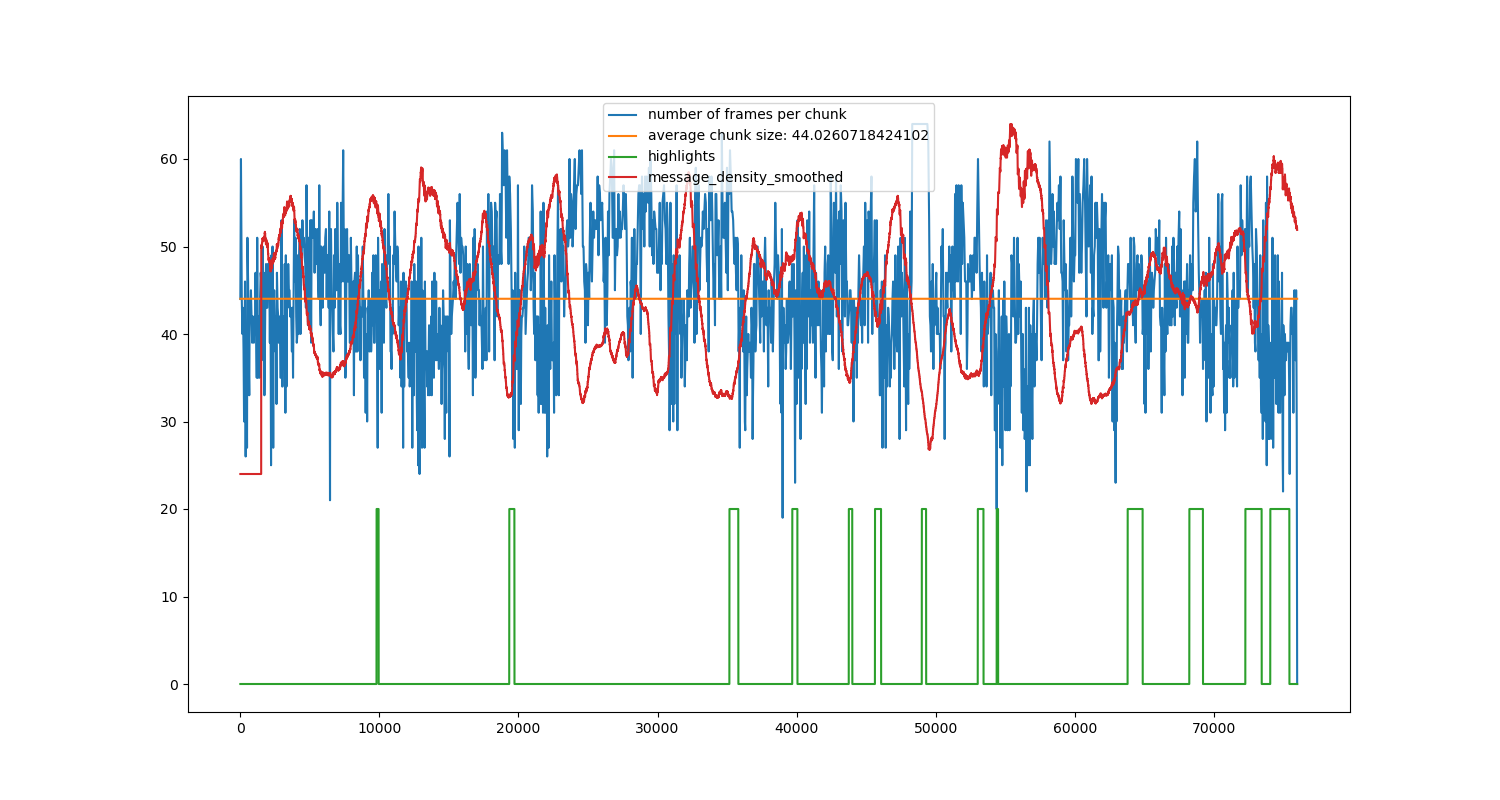

In [202]:
%matplotlib widget

plt.plot(ds_chunk_end_inds[0], ds_chunk_len_frames[0], label="number of frames per chunk")
plt.plot(range(len(chd.highlights["nalcs_w4d3_FLY_C9_g1"])), [sum(ds_chunk_len_frames[0]) / len(ds_chunk_len_frames[0])] * len(chd.highlights["nalcs_w4d3_FLY_C9_g1"]), label=f"average chunk size: {sum(ds_chunk_len_frames[0]) / len(ds_chunk_len_frames[0])}")
plt.plot(range(len(chd.highlights["nalcs_w4d3_FLY_C9_g1"])), chd.highlights["nalcs_w4d3_FLY_C9_g1"] * 20, label = "highlights")
plt.plot(range(len(chd.get_chat_measure("message_density")["nalcs_w4d3_FLY_C9_g1"])), msg_density, label="message_density_smoothed")
plt.legend()
plt.show()

In [201]:
chd.chat.keys()

dict_keys(['nalcs_w4d3_FLY_C9_g1', 'nalcs_w1d3_NV_CLG_g1', 'nalcs_w7d3_CLG_C9_g1', 'nalcs_w1d3_TSM_IMT_g1', 'nalcs_w7d3_TL_NV_g1', 'nalcs_w1d3_TL_FLY_g1', 'nalcs_w4d3_FOX_TSM_g1', 'nalcs_w7d3_FOX_DIG_g1', 'nalcs_w4d3_DIG_NV_g1', 'nalcs_w4d3_CLG_P1_g1', 'nalcs_w1d3_DIG_C9_g1', 'nalcs_w7d3_IMT_TSM_g1'])

In [94]:
len(chd.highlights["nalcs_w4d3_FLY_C9_g1"])

75989